In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons,make_blobs
from sklearn.metrics import accuracy_score

A couple of helper functions we can use:

In [141]:
def sample_2d_gaussian(meanx,meany,variance_x,variance_y,covariance,numsamps):
    '''
    Generates a random sample of size 'numsamps' from a 2-dimensional Gaussian distribution.
    The Gaussian is defined by the mean vector (meanx,meany) and the 
    covariance matrix
    
    variance_x    covariance
    covariance    variance_y
    
    All parameters can be freely chosen, except covariance, which must satisfy the inequality
    
    covariance <= sqrt(variance_x * variance_y)
    '''
    meanvec = np.array([meanx,meany])
    covarmatrix = np.array([[variance_x,covariance],[covariance,variance_y]])
    return multivariate_normal(meanvec,covarmatrix,numsamps)


def maxpos(A):
    '''
    Takes an n x k array A, and returns 1-dim n array where the i'th
    entry is the index of column in A where the i'th row of A has its
    maximal value (application: turns a probabilitiy distribution over
    k classes for n instances into a single prediction)
    '''
    return np.argmax(A,axis=1)
    

### Part 1: Decision regions for simple 2 dimensional datasets

Loading/generating data: following are several alternative ways to get data consisting of the input features stored in 'features', and the class labels, stored in 'labels'.  Only execute one of the data generating cells, before moving on to the following code!

**A**: sampling data from 2-dimensional Gaussian distributions. For reproducibility, one can fix a random seed.

In [355]:
np.random.seed(1)
datasize=1500
mixturecoeff=np.array([0.4,0.2,0.4])
componentsizes=(datasize*mixturecoeff).astype(int)

class0samp=sample_2d_gaussian(2,3,8,5,.5,componentsizes[0])
class1samp=sample_2d_gaussian(8,9,8,5,-0.5,componentsizes[1])
#class2samp=sample_2d_gaussian(3,2,0.5,0.5,0.5,componentsizes[2])
  
features=np.concatenate((class0samp,class1samp),axis=0)
labels=np.concatenate((np.zeros(componentsizes[0]),np.ones(componentsizes[1])))  
print(features.shape)

(900, 2)


**B**: Loading mi.txt data:

In [344]:
np.random.seed(1)
midata = pd.read_table("MI-labeled.txt", sep=',')
features = np.array(midata[['X1','X2']])
classlabels=midata['Class']
labels = np.zeros(len(classlabels))
for i in range(len(classlabels)):
    if classlabels[i] == 'I':
        labels[i]=1
print (features.shape)

(119, 2)


Preparing meshgrid for plotting decision regions:

In [356]:
maxvalx = np.max(features[:,0])
maxvaly = np.max(features[:,1])
minvalx = np.min(features[:,0])
minvaly = np.min(features[:,1])
border=2
xinterval = (maxvalx-minvalx)/border
yinterval = (maxvaly-minvaly)/border
xx, yy = np.meshgrid(np.arange(minvalx-xinterval, maxvalx+xinterval, xinterval/100), np.arange(minvaly-yinterval, maxvaly+yinterval, yinterval/100))
print(xx.shape)

(400, 400)


Learning a classifier -- uncomment to select the classification model to use.

In [357]:
model=GaussianNB()
model=LinearDiscriminantAnalysis()
model = LogisticRegression(penalty='l1')
model = SVC(kernel='linear')

model.fit(features,labels)
print(features.shape)

(900, 2)


Applying model to the meshgrid. All models return a quantitative "likelihood" for the different classes. For the probabilistic models, these are class label probabilities that are retrieved using the `.predict_proba` method. For the non-probabilistic SVC model, this is the `decision_function` method. In all cases, we classify a datapoint as belonging to the class with the maximal "likelihood" value.

In [358]:
#Z=model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z=model.decision_function(np.c_[xx.ravel(), yy.ravel()])
print(Z.shape[0])
#meshclasses = maxpos(Z.reshape([Z.shape[0],2]))
meshclasses = np.ones(Z.size)
print(Z)
meshclasses[Z<0]=0
meshclasses = meshclasses.reshape(xx.shape)
print(Z.shape)

160000
[-21.39275897 -21.34997052 -21.30718208 ...  20.94847861  20.99126706
  21.0340555 ]
(160000,)


Plotting datapoints and decision regions

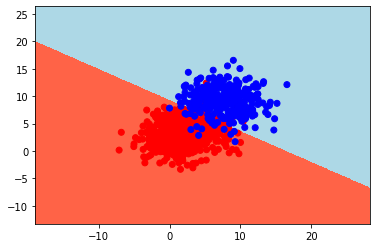

In [359]:
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
#plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b','g']))
plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b']))
plt.show()

In [360]:
print(Z)

[-21.39275897 -21.34997052 -21.30718208 ...  20.94847861  20.99126706
  21.0340555 ]


We also calculate the predictions on the (training) datapoints, and check the accuracy:

In [361]:
pred_labels=model.predict(features)
print("Accuracy: {}".format(accuracy_score(labels,pred_labels)))

Accuracy: 0.9522222222222222


**Exercise 1 [Linear],[SVM]**: Experiment with the three classifiers Gaussian Naive Bayes, Linear Discriminant Analysis, Logistic Regression, and linear support vector machines. Use the MI data, and different mixtures of Gaussians you create by varying the parameters in `sample_2d_gaussian'. 

For the Gaussian mixture data:

Create one or several linearly separable Gaussian mixture datasets (can be with only two components) for which some of the models give a perfect separation of the classes, and others don't. 

Create separate test sets using the same parameters for the Gaussian mixture as in the creation of the training set. Can you create a test/train dataset and find classifiers A and B, such that A is better than B on the training data, but B is better than A on the test set? Why is this not such an easy task for the datasets and classifiers we consider her?

For the MI data:

explain the structure of the decision regions you find for the different classifiers.


In [365]:
'''Gaussian mixture data part
 Its not an easy task cause Gaussian processes are sensible to overfitting when your datasets are too small, especially when you have a weak prior knowledge of the covariance structure (because the optimal set of hyperparameters for the covariance kernel often makes no sense). Regarding the SVMs,
 by using a linear kernel even though is way faster than a RBF or polynomial it is more prone to overfitting it doesnt fit the data that well. Using other type of kernel and increasing the size of the training'''

from sklearn.model_selection import train_test_split

x: np.ndarray = features
y: np.ndarray = labels
    
trnX, tstX, trnY, tstY = train_test_split(x, y, test_size=0.3,random_state=20) #vary the training size aswell, the smaller the test size the accuracy decreases

'''Classifier A
model = SVC(kernel='linear')
model.fit(trnX,trnY)

pred_labels=model.predict(tstX)
print("Accuracy: {}".format(accuracy_score(tstY,pred_labels)))'''
#Classifier B
model=GaussianNB()
#model=LinearDiscriminantAnalysis()
#model = LogisticRegression(penalty='l1')
#model = SVC(kernel='linear')
model.fit(trnX,trnY)

pred_labels_train=model.predict(trnX)
pred_labels=model.predict(tstX)
print("Accuracy test: {}".format(accuracy_score(tstY,pred_labels)))
print("Accuracy train: {}".format(accuracy_score(trnY,pred_labels_train)))

''' Regarding the MI data'''
#Gaussian

#LDA


#SVC


#LogisticRegression



Accuracy test: 0.9703703703703703
Accuracy train: 0.9396825396825397


' Regarding the MI data'

### Part 2: the Boston Housing data

We next investigate some "real" data: the Boston housing dataset contains information on different socio-economic features in different areas around Boston, and the median house value in these areas. The usual machine learning problem for this dataset is the regression problem of predicting the median value. We can turn it into a binary prediction problem whether the median value is above the median (of the median values). 

The `load_boston` function returns the dataset in the form of a dictionary with attributes DESCR, data, and target.

In [368]:
from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from IPython.display import display

import seaborn as sns
data = load_boston()

print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

We generate our labels, and create a train/test split:

In [434]:


labels = np.array([1 if y > np.median(data['target']) else 0 for y in data['target']])
features = data['data']
labels_1 = data['target']
dfcolumns = pd.DataFrame(features)

print(labels)
print(dfcolumns.as_matrix(columns=dfcolumns.columns[::9]))


features_train,features_test,labels_train,labels_test = train_test_split(dfcolumns.as_matrix(columns=dfcolumns.columns[::9]),labels)



[1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 

/home/starksultana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/starksultana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


Selecting a model class, learning, and measuring accuracy:

In [443]:
from sklearn.preprocessing import StandardScaler
### Normalization step ###
features_train_norm=StandardScaler().fit_transform(features_train)
features_test_norm=StandardScaler().fit_transform(features_test)

##Selecting the best features 
model=GaussianNB()
model=LinearDiscriminantAnalysis()
model = LogisticRegression()
model = SVC(kernel='linear')

model.fit(features_train,labels_train)
pred_labels_train=model.predict(features_train_norm)
pred_labels_test=model.predict(features_test_norm)

print("Accuracy train: {}".format(accuracy_score(labels_train,pred_labels_train)))
print("Accuracy test: {}".format(accuracy_score(labels_test,pred_labels_test)))

Accuracy train: 0.49340369393139843
Accuracy test: 0.49606299212598426


**Exercise 2[Linear],[SVM]**: Try the different models on the Boston housing data. Which one is doing best in terms of test accuracy?

Inspect the following attributes of the learned models:

GaussianNB: `theta_`, `sigma_` <br>
LDA: `means_` <br>
Logistic regression: `coef_` <br>
SVC: `coef_`<br>

Check the online documentation about the meaning of these attributes. How can the values of these attributes be used for explaining the classification model? Which of the input features are most important for the prediction? 

For this investigation it may be helpful to normalize the data before building the classifiers, using the code in the cell below (why is this useful?).



In [409]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(features,labels)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features)
#concat two dataframes for better visualization 
#featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(dfscores)  #print 10 best features


              0
0   1019.305413
1   2640.411736
2    474.729689
3      8.666445
4      2.475553
5     10.302295
6   1316.167368
7     53.761071
8    517.172000
9   7146.288995
10    27.158021
11  1082.991588
12   895.521918


In [ ]:
'''Regarding the 1st part:'''
#Logistic Regression does the best job , with 0,87 and 0,86 even though is really close with LDA and SVC

'''2nd part'''
### -- GAUSSIAN
#sigma - array, shape (n_classes, n_features) variance of each feature per class
#theta - array, shape (n_classes, n_features) mean of each feature per class

### -- LDA 
#coef - coef_array, shape (n_features,) or (n_classes, n_features) Weight vector(s).
#means-  means_array-like, shape (n_classes, n_features) Class means.

### -- Logistic Regression
#coef -coef_ndarray of shape (1, n_features) or (n_classes, n_features) -Coefficient of the features in the decision function

### -- SVC
#coef - coef_array, shape = [n_class * (n_class-1) / 2, n_features] - Weights assigned to the features (coefficients in the primal problem). This is only available in the case of a linear kernel

#this attributes represent the way the classification models "work" or probablities or kernel functions with weights, e.g..

## regarding normalization - every dataset does not require normalization. It is required only when features have different ranges.Which happens in our dataset for example distances and ages have way different ranges

#cant do this on jupyter rather do it on vscode



